<a href="https://colab.research.google.com/github/SLVmain/NLP/blob/Les_04/HW_04_lda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Урок 4. Тематическое моделирование. EM-алгоритм
Задача тематическое моделирование

продолжаем исследование датасета с твитами

Скачиваем датасет (источник): положительные, отрицательные.

или можно через ноутбук

!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

как альтернатива можно скачать данные из Роспотребнадзора
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук parse_rospotrebnadzor.ipynb
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

## Закачка данных

In [1]:
import requests
from bs4 import BeautifulSoup 
import time
from urllib.parse import urlparse, urljoin
from tqdm.notebook import tqdm

In [68]:
## найти id каждого вопроса на страницах
page = 1
main_url = 'https://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page={page}&searchtext=&categories=[]'

def ids_from_page(soup):
    return [i.get('href') for i  in soup.findAll('a', {'class':'appeal-title-link'})]
    
urls = []
for page in tqdm(range(1, 1000), desc='Pages'):
    time.sleep(0.5)
    res = requests.get(main_url.format(page=page))  
    soup = BeautifulSoup(res.text)
    urls.extend(ids_from_page(soup))

Pages:   0%|          | 0/999 [00:00<?, ?it/s]

In [69]:
## имея id запросов достанем тексты на страницах
domain = 'https://zpp.rospotrebnadzor.ru'

def get_text_page_question(soup):
    return soup.findAll('p', {'class':'appeal-details-message'})[0].text
def get_text_page_answer(soup):
    return soup.findAll('p', {'class':'appeal-comments-message'})[0].text

questions = []
answers = []

for url in tqdm(urls, desc='Pages'):
    time.sleep(0.5)
    res = requests.get(urljoin(domain, url))  
    soup = BeautifulSoup(res.text)
    
    questions.append(get_text_page_question(soup))
    try:
        answers.append(get_text_page_answer(soup))
    except:
        answers.append('No answer')

Pages:   0%|          | 0/4995 [00:00<?, ?it/s]

In [70]:
## посмотрим, что скачалось
N = 2
print('Q:', questions[N])
print()
print('A:', answers[N])

Q: Добрый день. По адресу Всеволожск,Всеволожский проспект 72 в торговом центре и во всех расположенных в этом здании магазинах есть мыши. Они бегают по торговому залу,вылезают из ламп из потолка. Прошу зарегестрировать моё обращение и провести проверку.

A: Раздел «Виртуальная приёмная» ГИР ЗПП представляет собой площадку для общения между потребителем и Роспотребнадзором. Ваше обращение может быть рассмотрено в рамках полномочий Роспотребнадзора в соответствии с требованиями Федерального закона от 02.05.2006 № 59-ФЗ «О порядке рассмотрения обращений граждан Российской Федерации» Вы можете направить официальное обращение на почту: Адрес: 192029, Санкт-Петербург, ул. Ольминского, д. 27. сайт:http://47.rospotrebnadzor.ru/ в разделе «Прием обращений граждан». e-mail: lenobl@47.rospotrebnadzor.ru


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
len(questions)

4995

In [73]:
import pickle
path = '/content/drive/MyDrive/data/'

with open(path + "questions_file1k.pkl", 'wb') as f:
  pickle.dump(questions, f)

In [3]:
import pickle
path = '/content/drive/MyDrive/data/'

In [4]:
with open(path + "questions_file1k.pkl", 'rb') as f:
     questions1 = pickle.load(f)

In [5]:
len(questions1)

4995

In [6]:
questions1[2]

'Добрый день. По адресу Всеволожск,Всеволожский проспект 72 в торговом центре и во всех расположенных в этом здании магазинах есть мыши. Они бегают по торговому залу,вылезают из ламп из потолка. Прошу зарегестрировать моё обращение и провести проверку.'

### Предобработка


Все модели, с которыми мы будем работать далее, работают с предобработанными текстами, поэтому сперва проведем стандартную предобработку текста:

In [7]:
import re
import numpy as np
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool
from pymystem3 import Mystem

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
! pip install pymorphy2

In [10]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [11]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')
morestopwords = ['это', 'который', "каждый"]
stopwords_list += morestopwords

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [77]:
morestopwords = ['это', 'который', 'каждый']
stopwords_list += morestopwords

In [12]:
questions1[1]

'Добрый день!\r\nПо всей стране вспышки простуды, больничных, коронавируса, а по телевизору ни слова, почему?'

In [13]:
print(preprocess(questions1[1]))

['добрый', 'день', 'весь', 'страна', 'вспышка', 'простуда', 'больничный', 'коронавирус', 'телевизор', 'слово', 'почему']


In [15]:
preprocessed_q = list(tqdm(map(preprocess, questions1), total=len(questions1)))

  0%|          | 0/4995 [00:00<?, ?it/s]

## Модель LDA


Первая модель, которую мы рассмотрим, LDA - латентное размещение Дирихле. Воспользуемся реализацией из библиотеки gensim.

In [ ]:
!pip install -U gensim

In [16]:
from gensim.models import *
from gensim import corpora

Модель использует векторное представление документов, например, мешок слов (bow), поэтому сперва создадим словарь:

In [17]:
dictionary = corpora.Dictionary(preprocessed_q)

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save(path+'question.dict')

Векторизуем документы:

In [18]:
corpus = [dictionary.doc2bow(text) for text in preprocessed_q]
corpora.MmCorpus.serialize(path+'rosnadzor.model', corpus) 

In [19]:
print(corpus[:1])

[[(0, 1), (1, 3), (2, 2), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1)]]


In [20]:
%time 
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


In [21]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(15,
  '0.098*"гражданин" + 0.065*"территория" + 0.056*"просить" + 0.051*"место" + 0.047*"область" + 0.046*"проживать" + 0.045*"год" + 0.042*"санитарный" + 0.035*"граница" + 0.032*"норма"'),
 (16,
  '0.083*"детский" + 0.075*"сад" + 0.072*"родитель" + 0.058*"июнь" + 0.051*"год" + 0.051*"билет" + 0.032*"место" + 0.032*"проведение" + 0.030*"мероприятие" + 0.029*"тысяча"'),
 (8,
  '0.053*"право" + 0.043*"находиться" + 0.041*"закон" + 0.037*"потребитель" + 0.033*"правило" + 0.032*"согласно" + 0.032*"требование" + 0.027*"лицо" + 0.026*"защита" + 0.025*"соответствие"'),
 (3,
  '0.053*"день" + 0.024*"добрый" + 0.024*"сказать" + 0.023*"мочь" + 0.019*"всё" + 0.017*"вопрос" + 0.017*"россия" + 0.016*"время" + 0.016*"здравствуйте" + 0.015*"сотрудник"'),
 (7,
  '0.119*"заказ" + 0.070*"товар" + 0.052*"доставка" + 0.038*"сайт" + 0.031*"поддержка" + 0.029*"оплатить" + 0.028*"забрать" + 0.026*"интернет" + 0.025*"служба" + 0.025*"сутки"'),
 (17,
  '0.129*"магазин" + 0.091*"товар" + 0.051*"продавец" + 0.

На полученные темы можно посмотреть, изобразив их на плоскости с помощью библиотеки __pyLDAvis__. Чтобы спроецировать темы на плоскость, внутри применяется PCA-разложение.

In [ ]:
!pip install pyLDAvis

In [22]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%time 
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:

In [23]:
print(lda.log_perplexity(corpus))


-14.20214497217321


In [24]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  6.792783929776821e-07


In [25]:
coherence_model_lda = CoherenceModel(model=lda, texts=preprocessed_q, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.3502587212745508


Теперь можно подобрать оптимальное количество тем, опираясь на значение метрик:

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

  0%|          | 0/13 [00:00<?, ?it/s]

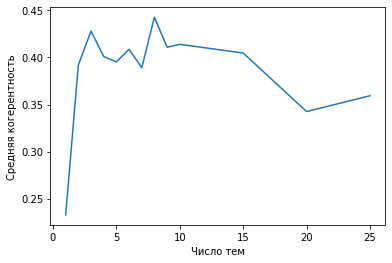

In [31]:
topics_list = [1, 2, 3, 4, 5, 6, 7 , 8, 9, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=preprocessed_q, dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [33]:
lda_8 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=8, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_8, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [34]:
lda_8.show_topics(num_topics=8, num_words=10, formatted=True)

[(0,
  '0.035*"гражданин" + 0.023*"территория" + 0.017*"право" + 0.015*"мусор" + 0.015*"правило" + 0.014*"иметь" + 0.013*"постановление" + 0.012*"закон" + 0.012*"санитарный" + 0.012*"российский"'),
 (1,
  '0.031*"день" + 0.019*"год" + 0.016*"средство" + 0.016*"апрель" + 0.015*"требование" + 0.014*"сад" + 0.014*"документ" + 0.014*"родитель" + 0.014*"май" + 0.013*"срок"'),
 (2,
  '0.050*"услуга" + 0.049*"договор" + 0.034*"компания" + 0.024*"ремонт" + 0.022*"вода" + 0.022*"сдать" + 0.013*"поездка" + 0.012*"замена" + 0.011*"связь" + 0.010*"акт"'),
 (3,
  '0.035*"дом" + 0.026*"ребёнок" + 0.021*"адрес" + 0.021*"просить" + 0.015*"год" + 0.013*"наш" + 0.010*"всё" + 0.009*"работать" + 0.009*"проверка" + 0.009*"covid"'),
 (4,
  '0.046*"товар" + 0.042*"магазин" + 0.037*"тест" + 0.030*"день" + 0.022*"заказ" + 0.021*"продавец" + 0.020*"пцр" + 0.018*"россия" + 0.015*"нужно" + 0.015*"добрый"'),
 (5,
  '0.021*"сайт" + 0.018*"день" + 0.017*"ответ" + 0.015*"просить" + 0.015*"сотрудник" + 0.014*"получить

Можно попробовать определить темы: номер 7 - нахождение в масках в детских садах, номер 6 - возврат денег, номер 5 - проблемы с коммуникацией на сайтах, номер 4 - проблема с покупкой товаров в магазине, 3 - выплаты по детям?,  2 - обращения по услугам по ремноту, 1 - ??, 0 - уборка мусора. 